---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/15 05:21:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

25/04/15 05:21:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [11]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

data = df.dropna(subset=[
    "SALARY", 
    "MIN_YEARS_EXPERIENCE", 
    "MODELED_DURATION", 
    "NAICS2_NAME"
])

categorical_cols = ["NAICS2_NAME"]
numerical_cols = ["MIN_YEARS_EXPERIENCE", "MODELED_DURATION"]

# Create indexers and encoders for all categorical variables:
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
            for c in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec")
            for c in categorical_cols]

# --- Step 2: Pipeline for Feature Engineering ---
# Create StringIndexers for categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip") for c in categorical_cols]

# Create OneHotEncoders for the indexed categorical columns
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_vec") for c in categorical_cols]

# Create a VectorAssembler to combine continuous and encoded categorical columns into a single feature vector
assembler = VectorAssembler(
    inputCols=numerical_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)


# Build the pipeline with the stages
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit the pipeline and transform the data; now final_data will have the "features" column.
pipeline_model = pipeline.fit(data)
final_data = pipeline_model.transform(data)

# Optionally verify that the "features" column is present:
final_data.select("SALARY", "features").show(5, False)



+------+---------------------------+
|SALARY|features                   |
+------+---------------------------+
|75026 |(22,[0,1,4],[2.0,21.0,1.0])|
|60923 |(22,[0,1,9],[1.0,21.0,1.0])|
|131100|(22,[0,1,2],[2.0,11.0,1.0])|
|136950|(22,[0,1,3],[3.0,28.0,1.0])|
|122500|(22,[0,1,6],[5.0,24.0,1.0])|
+------+---------------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [12]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(2175, 134)


(485, 134)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [24]:
from pyspark.ml.regression import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate

reg_model = LinearRegression(featuresCol="features", labelCol="SALARY")
fitted_model = reg_model.fit(train_data)
model_info = fitted_model.summary

n_features = len(fitted_model.coefficients)
names = ["Intercept"] + [f"Feature_{i}" for i in range(n_features)]

estimates = [fitted_model.intercept] + list(fitted_model.coefficients)
std_errors = [None] + (model_info.coefficientStandardErrors if model_info.coefficientStandardErrors else [None]*n_features)
t_stats    = [None] + (model_info.tValues if model_info.tValues else [None]*n_features)
p_vals     = [None] + (model_info.pValues if model_info.pValues else [None]*n_features)

combined_rows = list(zip(names, estimates, std_errors, t_stats, p_vals))
coef_summary = pd.DataFrame(combined_rows,
                            columns=["Feature", "Coefficient", "Std Error", "t Value", "p Value"])

print("\n--- Coefficient Summary ---")
print(coef_summary.to_string(index=False))


25/04/15 06:01:57 WARN Instrumentation: [bf1a49c5] regParam is zero, which might cause numerical instability and overfitting.



--- Coefficient Summary ---
   Feature   Coefficient    Std Error   t Value  p Value
 Intercept  74869.070230          NaN       NaN      NaN
 Feature_0   8776.650588   258.440347 33.960063 0.000000
 Feature_1    115.742489    48.634795  2.379829 0.017407
 Feature_2   4567.290709 19814.609673  0.230501 0.817724
 Feature_3   4126.432847 19820.646266  0.208189 0.835101
 Feature_4  -3241.289769 19852.743207 -0.163267 0.870324
 Feature_5 -15622.729266 19839.297418 -0.787464 0.431097
 Feature_6  -7898.183950 19861.886596 -0.397655 0.690924
 Feature_7  -2538.627566 19887.434855 -0.127650 0.898438
 Feature_8  -6362.419531 19979.132688 -0.318453 0.750172
 Feature_9 -17512.939877 19982.636868 -0.876408 0.380906
Feature_10  -7055.818396 20022.094468 -0.352402 0.724572
Feature_11  10925.426835 20051.239596  0.544875 0.585896
Feature_12   2350.157449 20127.042924  0.116766 0.907056
Feature_13  12303.821558 20167.461149  0.610083 0.541871
Feature_14 -13577.618234 20831.803589 -0.651774 0.514617
Fe

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [25]:
#| eval: true
#| echo: false
coef_entries = [
    {"Estimate": est, "Std Error": se, "t-stat": tval, "P-Value": pval} 
    for est, se, tval, pval in zip(estimates, std_errors, t_stats, p_vals)
]
coef_table = pd.DataFrame(coef_entries)
print("\n", tabulate(coef_table, headers="keys", tablefmt="pretty"))



 +----+---------------------+--------------------+----------------------+----------------------+
|    |      Estimate       |     Std Error      |        t-stat        |       P-Value        |
+----+---------------------+--------------------+----------------------+----------------------+
| 0  |  74869.0702296085   |        nan         |         nan          |         nan          |
| 1  |  8776.65058796539   | 258.4403469622957  |   33.9600634774176   |         0.0          |
| 2  | 115.74248862280427  | 48.63479523905706  |  2.3798288458682593  | 0.017407341882905714 |
| 3  |  4567.29070918178   | 19814.609672769053 | 0.23050116982412955  |  0.8177242639363689  |
| 4  |  4126.432847252102  | 19820.646265819294 | 0.20818861261694255  |  0.8351014004161466  |
| 5  | -3241.2897691974135 | 19852.74320653086  | -0.16326659421712272 |  0.8703238650407279  |
| 6  | -15622.729265963675 |  19839.2974178885  | -0.7874638368935952  |  0.4310971091371987  |
| 7  | -7898.183949905432  | 19861.886

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


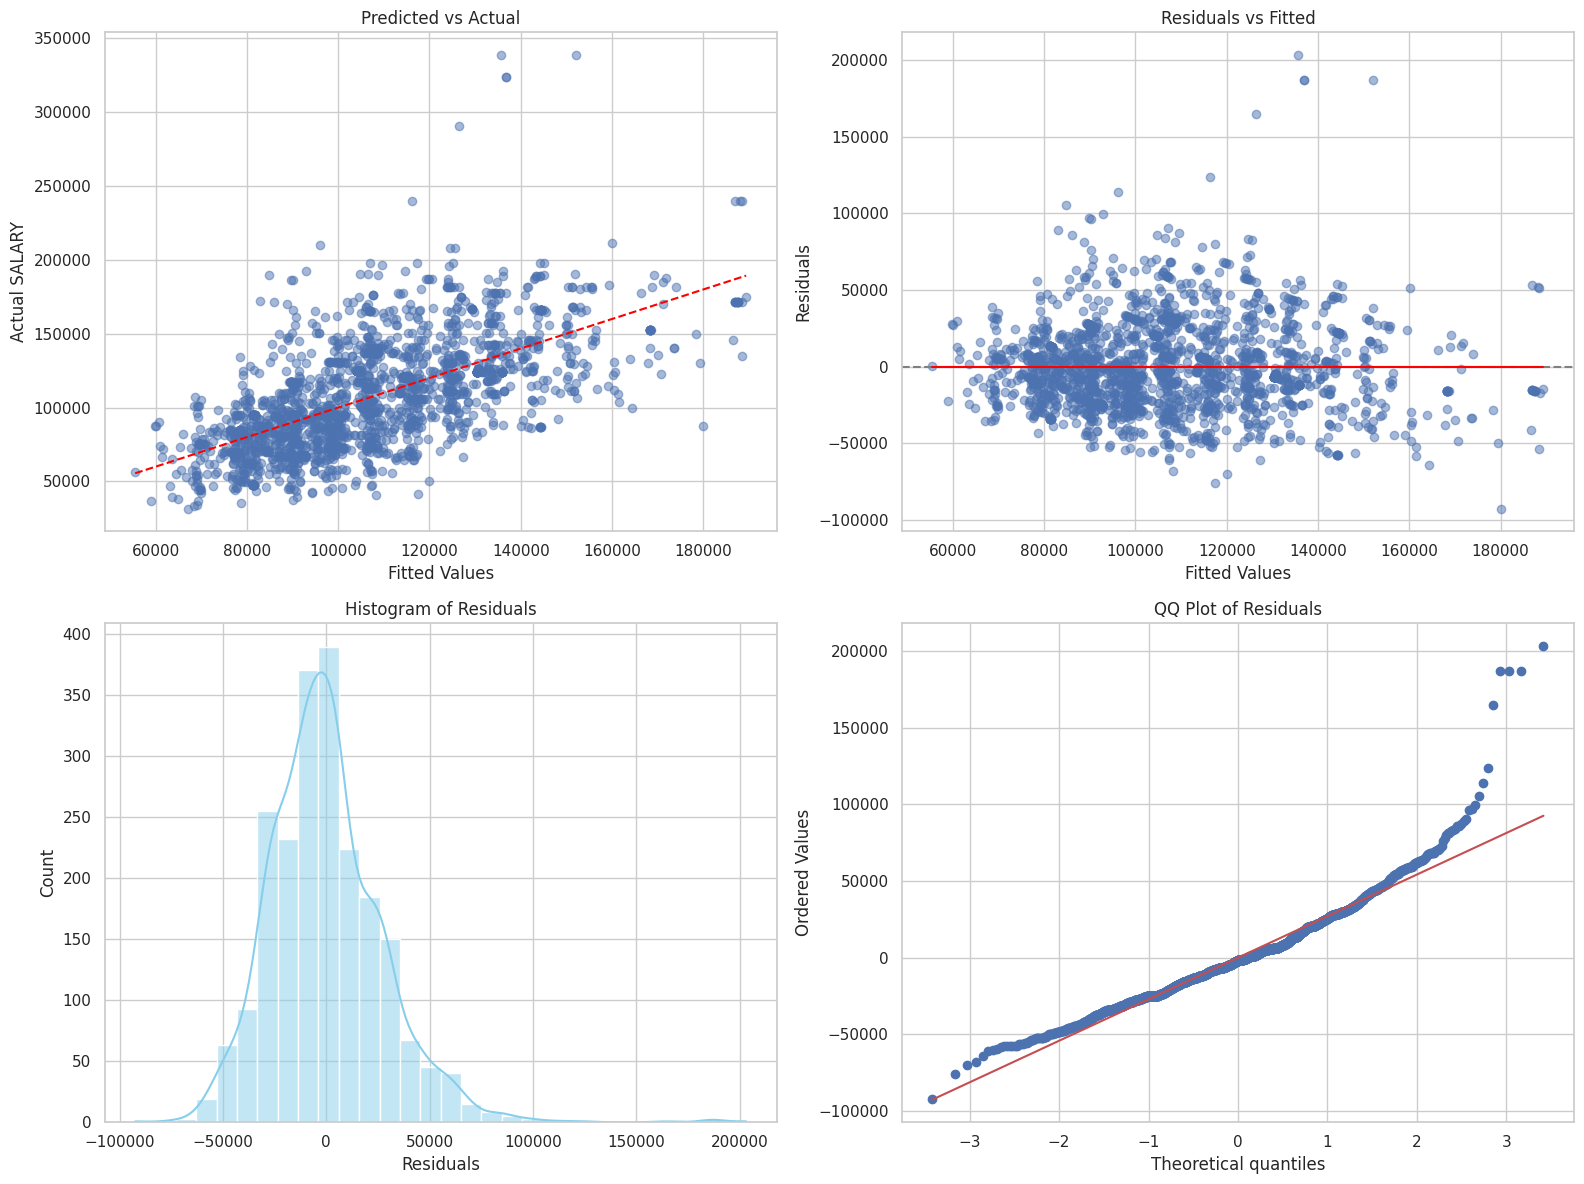

In [26]:
predictions_pd = model_info.predictions.toPandas()

predictions_pd["Residual"] = predictions_pd["SALARY"] - predictions_pd["prediction"]
predictions_pd["Fitted"] = predictions_pd["prediction"]

res_mean = predictions_pd["Residual"].mean()
res_std  = predictions_pd["Residual"].std()
predictions_pd["StdResid"] = (predictions_pd["Residual"] - res_mean) / res_std

predictions_pd["SqrtAbsStdResid"] = np.sqrt(np.abs(predictions_pd["StdResid"]))

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Plot 1: Residuals vs Fitted
axs[0, 0].scatter(predictions_pd["Fitted"], predictions_pd["SALARY"], alpha=0.5)
min_fit, max_fit = predictions_pd["Fitted"].min(), predictions_pd["Fitted"].max()
axs[0, 0].plot([min_fit, max_fit], [min_fit, max_fit], color="red", linestyle="--")
axs[0, 0].set_title("Predicted vs Actual")
axs[0, 0].set_xlabel("Fitted Values")
axs[0, 0].set_ylabel("Actual SALARY")

# Plot 2:
axs[0, 1].scatter(predictions_pd["Fitted"], predictions_pd["Residual"], alpha=0.5)
axs[0, 1].axhline(0, color="gray", linestyle="--")
poly_params = np.polyfit(predictions_pd["Fitted"], predictions_pd["Residual"], 1)
trend_line = np.poly1d(poly_params)
sorted_fit = np.linspace(min_fit, max_fit, 100)
axs[0, 1].plot(sorted_fit, trend_line(sorted_fit), color="red")
axs[0, 1].set_title("Residuals vs Fitted")
axs[0, 1].set_xlabel("Fitted Values")
axs[0, 1].set_ylabel("Residuals")

# Plot 3:
sns.histplot(predictions_pd["Residual"], bins=30, kde=True, color="skyblue", ax=axs[1, 0])
axs[1, 0].set_title("Histogram of Residuals")
axs[1, 0].set_xlabel("Residuals")

# Plot 4:
stats.probplot(predictions_pd["Residual"], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("QQ Plot of Residuals")

plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()


In [27]:
import pyspark.sql.functions as F
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [28]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

predictions = lr_model.transform(test_data)

evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol="SALARY", predictionCol="prediction")
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="SALARY", predictionCol="prediction")
r2_value  = evaluator_r2.evaluate(predictions)
rmse_auto = evaluator_rmse.evaluate(predictions)

sample_count = test_data.count()
param_total  = len(lr_model.coefficients) + 1

pred_with_error = predictions.withColumn("error_sq", F.pow(F.col("SALARY") - F.col("prediction"), 2))
rss_total = pred_with_error.agg({"error_sq": "sum"}).collect()[0][0]

bic_value = sample_count * np.log(rss_total / sample_count) + param_total * np.log(sample_count)

avg_error_sq = pred_with_error.select(F.avg("error_sq")).collect()[0][0]
rmse_manual = np.sqrt(avg_error_sq)

print("----- Evaluation Results -----")
print(f"R² (test set):       {r2_value:.4f}")
print(f"RMSE (built-in):     {rmse_auto:.2f}")
print(f"RMSE (manual):       {rmse_manual:.2f}")
print(f"BIC (manual, test):  {bic_value:.2f}")

----- Evaluation Results -----
R² (test set):       0.3896
RMSE (built-in):     28680.33
RMSE (manual):       28680.33
BIC (manual, test):  10098.28


## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

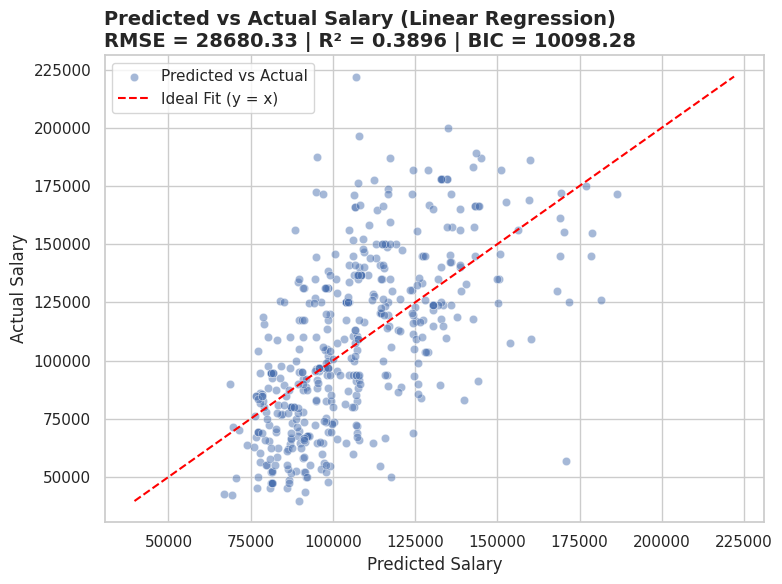

In [29]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = predictions.select("SALARY", "prediction").toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="prediction", y="SALARY", alpha=0.5, label="Predicted vs Actual")

min_val = min(plot_df["SALARY"].min(), plot_df["prediction"].min())
max_val = max(plot_df["SALARY"].max(), plot_df["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Ideal Fit (y = x)")

plt.title(
    f"Predicted vs Actual Salary (Linear Regression)\n"
    f"RMSE = {rmse_manual:.2f} | R² = {r2_value:.4f} | BIC = {bic_value:.2f}",
    loc="left", fontsize=14, fontweight="bold"
)

plt.xlabel("Predicted Salary")
plt.ylabel("Actual Salary")
plt.legend()
plt.tight_layout()

plt.savefig("_output/lr_predicted_vs_actual.png", dpi=300)
plt.show()

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
